In [3]:
from IPython.core.display import display, HTML
# Full display of notebook (width of screen)
display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# Import basic libraries
import os, glob, sys
import numpy as np   
import pandas as pd 

# Define librearies needed for analysis
import matplotlib.pyplot as plt # Matplotlibrary
import seaborn as sns # Seaborn Library

# Plotting pretty figures
import itertools
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams['font.size']       = 19
plt.rcParams['figure.figsize']  = (12.0, 7.0)
plt.rcParams['lines.linewidth'] = 2

SMALL_SIZE = 19
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc('font',  size = SMALL_SIZE)
plt.rc('axes',  titlesize = MEDIUM_SIZE)
plt.rc('xtick', labelsize = MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize = MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('axes',  linewidth = 2)

params = {
            'xtick.major.width': 2.15,
            'xtick.minor.width': 1.25,
            'xtick.major.size': 8,
            'xtick.minor.size': 3.5,
            'ytick.major.width': 2.15,
            'ytick.minor.width': 1.25,
            'ytick.major.size': 8,
            'ytick.minor.size': 3.5
         }

plt.rcParams.update(params)

feat_path = os.path.join(os.path.abspath(os.path.dirname(os.path.dirname(os.getcwd()))))
if feat_path not in sys.path:
    sys.path.append(feat_path)
    
%load_ext autoreload
%autoreload 2

np.random.seed(42)

# use xkcd plotting
plt.xkcd() # https://stackoverflow.com/questions/19663986/getting-xkcd-plots-using-matplotlib/22812176

# get additional tools
from src.utils import utils 
from src.train import pipeline
from src.test import predict

# Define path where data is located and folder to access to it
path_data = os.path.join(os.path.abspath(os.path.dirname(os.path.dirname(os.getcwd()))),'data','external')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Data pre-processing

In [4]:
# load data in pd dataframe
train, test = utils.load_data(path_data)
# Fill test data by defaut value
test['Survived'] = 666

data = pd.concat([train,test])

In [5]:
# Apply all data transformations from EDA
data = pipeline.transformation_features(data)
data = utils.drop_features(data, ['Ticket', 'Cabin' ,'Name'])
data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,Title,Deck,Has_Cabin,Type_Ticket,Words_Count
0,1,0,3,male,B,1,0,A,S,B,Mr,None,No,139,4
1,2,1,1,female,C,1,0,D,C,B,Mrs,C,Yes,154,7
2,3,1,3,female,B,0,0,B,S,A,Miss,None,No,165,3
3,4,1,1,female,C,1,0,D,S,B,Mrs,C,Yes,3,7
4,5,0,3,male,C,0,0,B,S,A,Mr,None,No,108,4


In [6]:
# Define features to transform
other_features   = ['PassengerId', 'Survived', 'Pclass', 'SibSp', 'Parch', 'Type_Ticket', 'Words_Count']
cat_ord_features = ['Deck', 'Has_Cabin']
cat_hot_features = ['Sex', 'Age', 'Fare', 'Embarked', 'FamilySize', 'Title']

In [7]:
data = pipeline.pipeline_features(data, cat_ord_features, cat_hot_features, other_features)
data.head()

,Deck,Has_Cabin,Sex_female,Sex_male,Age_A,Age_B,Age_C,Age_D,Age_E,Fare_A,...,Title_Mr,Title_Mrs,Title_Rare,PassengerId,Survived,Pclass,SibSp,Parch,Type_Ticket,Words_Count
0,7.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,3.0,1.0,0.0,139.0,4.0
1,2.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,2.0,1.0,1.0,1.0,0.0,154.0,7.0
2,7.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,1.0,3.0,0.0,0.0,165.0,3.0
3,2.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,4.0,1.0,1.0,1.0,0.0,3.0,7.0
4,7.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,5.0,0.0,3.0,0.0,0.0,108.0,4.0


In [8]:
Y_train = data['Survived'][:len(train)]

X_train_data = data.drop(other_features[:2], axis=1)[:len(train)]
X_test  = data[len(train):]

X_train_data.shape, X_test.shape, Y_train.shape

((891, 29), (418, 31), (891,))

# 2. Result without tunning

In [9]:
# ML models
from sklearn.tree import DecisionTreeClassifier # Generic Decision Tree
from sklearn.ensemble import RandomForestClassifier # Random Forest
from sklearn.svm import SVC # Support Vector machine
from sklearn.linear_model import LogisticRegression # Logistic Regression
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Calculate Baseline
rfc = RandomForestClassifier(n_estimators=500, random_state=24, n_jobs = -1)
dtc = DecisionTreeClassifier(random_state=24)
xgbo = XGBClassifier(random_state=24, n_jobs = -1)
lgbw = LGBMClassifier(learning_rate = 0.05, n_jobs=-1)
sgd = SGDClassifier(loss=  "log", random_state=24, n_jobs = -1)
svc = SVC(probability=True, random_state=24)
lrc = LogisticRegression(random_state=24, n_jobs = -1)
knc = KNeighborsClassifier(n_jobs = -1)

# Initialize a dictionary to save the results.
results = pd.DataFrame(columns=['Model','best_params','cv_acc','cv_acc_std'])

# Models
clfs = {'SGD'     : sgd,
        'LR'      : lrc,
        'DT'      : dtc,
        'RF'      : rfc,
        'KN'      : knc,
        'lgb'     : lgbw,
        'XGB'     : xgbo }

for name, model in clfs.items():
    
    cv_  = cross_val_score(model, X_train_data, Y_train, cv=StratifiedKFold(n_splits=5),  scoring = 'accuracy')
    results = utils.bookkeeping_results(results, name, model, cv_)
    
print('Done')

Done


In [10]:
# check on results
results.style.highlight_max(subset='cv_acc', color = 'yellow', axis = 0)

,Model,best_params,cv_acc,cv_acc_std
0,SGD,"{'alpha': 0.0001, 'average': False, 'class_weight': None, 'early_stopping': False, 'epsilon': 0.1, 'eta0': 0.0, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'loss': 'log', 'max_iter': 1000, 'n_iter_no_change': 5, 'n_jobs': -1, 'penalty': 'l2', 'power_t': 0.5, 'random_state': 24, 'shuffle': True, 'tol': 0.001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}",63.995355,19.165539
1,LR,"{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': -1, 'penalty': 'l2', 'random_state': 24, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}",82.040048,2.743863
2,DT,"{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': 24, 'splitter': 'best'}",78.116879,3.536421
3,RF,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'oob_score': False, 'random_state': 24, 'verbose': 0, 'warm_start': False}",79.801645,3.089667
4,KN,"{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': -1, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}",77.107526,2.684667
5,lgb,"{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.05, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}",84.062520,3.269496
6,XGB,"{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'gamma': None, 'gpu_id': None, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': None, 'max_delta_step': None, 'max_depth': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': -1, 'num_parallel_tree': None, 'random_state': 24, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}",81.709246,2.830740


In [12]:
# Save best results in MLFLOW
name_experiment = 'test_2'
predict.save_experiment_mlflow(name_experiment, results, top_3 = True, end_run = False)

INFO: 'test_2' does not exist. Creating a new experiment
Training information saved


In [ ]:
# Make predictions of a specific model
model_name = 'lgb'
submission = predict.make_prediction(clfs[model_name], X_train_data, Y_train, X_test) 

# Save predictions in desired format
submission.to_csv('submission_{}.csv'.format(model_name), index=False)

In [ ]:
#pip list

# 3. Result without tunning (with features selection)

In [11]:
from src.features.feature_selector import FeatureSelector

# New features selection for transformed data
train_labels = Y_train
train_ = X_train_data

fs = FeatureSelector(data = train_, labels = train_labels)

In [12]:
fs.identify_single_unique()

0 features with a single unique value.



In [13]:
fs.identify_collinear(correlation_threshold=0.95)

1 features with a correlation magnitude greater than 0.95.



In [14]:
# list of collinear features to remove
collinear_features = fs.ops['collinear']
# dataframe of collinear features
collinear_features

['Sex_male']

In [15]:
# Collinear plot of all maximally correlated features
#fs.identify_collinear(correlation_threshold=0.96)
#fs.plot_collinear()

In [16]:
fs.identify_zero_importance(task = 'classification', 
                            eval_metric = 'multi_logloss', 
                            n_iterations = 10, 
                            early_stopping = True)

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	valid_0's binary_logloss: 0.390159
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[72]	valid_0's binary_logloss: 0.282612
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.416281
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[200]	valid_0's binary_logloss: 0.339698
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[56]	valid_0's binary_logloss: 0.383915
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[70]	valid_0's binary_logloss: 0.359533
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[125]	valid_0's binary_logloss: 0.316139
Train

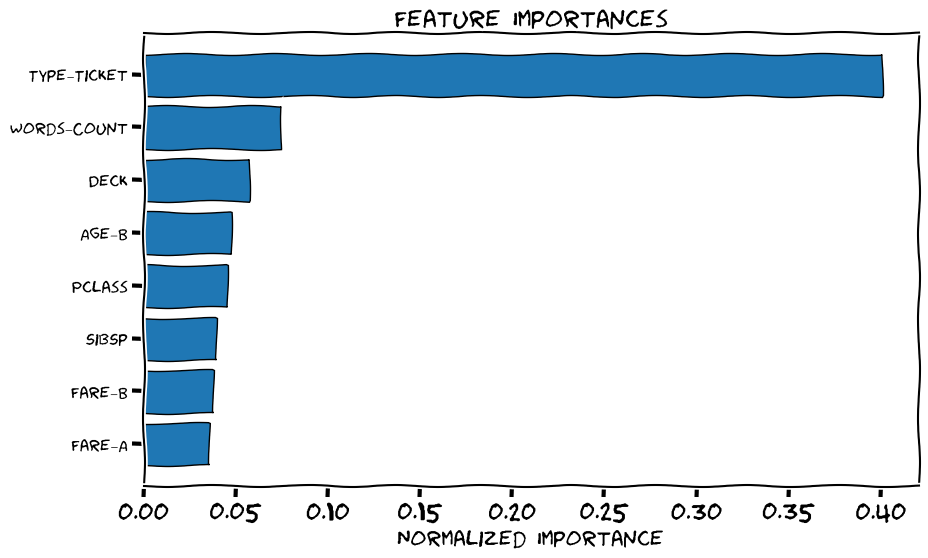

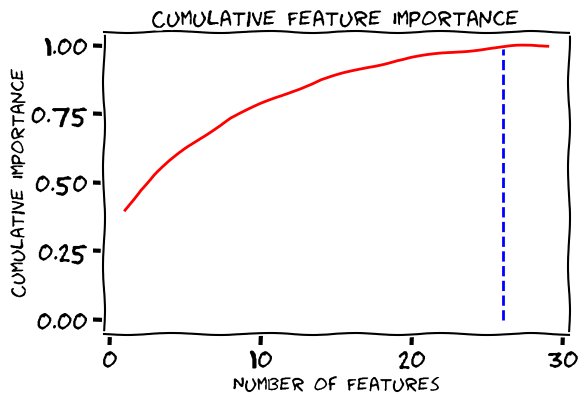

26 features required for 0.99 of cumulative importance


In [17]:
fs.plot_feature_importances(threshold = 0.99, plot_n = 8)

In [18]:
# gather all identified features for for removal
remove = fs.check_removal()

Total of 2 features identified for removal


In [19]:
# Remove features suggested for Training and Testing data
X_train_data = X_train_data.drop(np.intersect1d(remove, X_train_data.keys()), axis=1)
X_test       = X_test.drop(np.intersect1d(remove, X_test.keys()), axis=1)

In [20]:
X_test  = data[len(train):]
X_test = X_test.drop(other_features[:2], axis=1)
X_test

,Deck,Has_Cabin,Sex_female,Sex_male,Age_A,Age_B,Age_C,Age_D,Age_E,Fare_A,...,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Pclass,SibSp,Parch,Type_Ticket,Words_Count
891,7.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,81.0,3.0
892,7.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,3.0,1.0,0.0,98.0,5.0
893,7.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,45.0,4.0
894,7.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,77.0,3.0
895,7.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,3.0,1.0,1.0,74.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,7.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,137.0,3.0
1305,2.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,154.0,5.0
1306,7.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,164.0,4.0
1307,7.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,96.0,3.0


In [21]:
# Initialize a dictionary to save the results.
results = pd.DataFrame(columns=['Model','best_params','cv_acc','cv_acc_std'])

for name, model in clfs.items():
    
    cv_  = cross_val_score(model, X_train_data, Y_train, cv=StratifiedKFold(n_splits=5),  scoring = 'accuracy')
    results = utils.bookkeeping_results(results, name, model, cv_)
    
print('Done')

Done


In [22]:
# check on results
results.style.highlight_max(subset='cv_acc', color = 'yellow', axis = 0)

,Model,best_params,cv_acc,cv_acc_std
0,SGD,"{'alpha': 0.0001, 'average': False, 'class_weight': None, 'early_stopping': False, 'epsilon': 0.1, 'eta0': 0.0, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'loss': 'log', 'max_iter': 1000, 'n_iter_no_change': 5, 'n_jobs': -1, 'penalty': 'l2', 'power_t': 0.5, 'random_state': 24, 'shuffle': True, 'tol': 0.001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}",66.994539,14.069168
1,LR,"{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': -1, 'penalty': 'l2', 'random_state': 24, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}",81.928944,2.837606
2,DT,"{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': 24, 'splitter': 'best'}",76.994539,3.859999
3,RF,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'oob_score': False, 'random_state': 24, 'verbose': 0, 'warm_start': False}",80.139351,3.093407
4,KN,"{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': -1, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}",76.433369,2.487146
5,lgb,"{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.05, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}",84.062520,3.269496
6,XGB,"{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'gamma': None, 'gpu_id': None, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': None, 'max_delta_step': None, 'max_depth': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': -1, 'num_parallel_tree': None, 'random_state': 24, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}",81.821606,2.739113


In [ ]:
# Save best results in mlflow
#name_experiment = 'test_1_features_sel'
#predict.save_experiment_mlflow(name_experiment, results, top_3 = True, end_run = False)

In [ ]:
# Make predictions of a specific model
mod_name = 'lgb'
submission = predict.make_prediction(clfs[mod_name], X_train_data, Y_train, X_test) 

# Save predictions in desired format
submission.to_csv('submission_{}.csv'.format(mod_name), index=False)

# 4. Ensemble without tunning

In [25]:
from sklearn.ensemble import VotingClassifier

# Initialize a dictionary to save the results.
results = pd.DataFrame(columns=['Model','best_params','cv_acc','cv_acc_std'])

named_estimators = [ 
                     ('LR', dtc),
                     ('RF', rfc),
                     ('lgb' , lgbw),
                     ('XGB' , xgbo)
                    ]

voting_clf = VotingClassifier(named_estimators,voting='hard')
voting_clf.fit(X_train_data, Y_train)

cv_     = cross_val_score(voting_clf, X_train_data, Y_train, cv=StratifiedKFold(n_splits=5),  scoring = 'accuracy')
results = utils.bookkeeping_results(results, name, model, cv_)
results

,Model,best_params,cv_acc,cv_acc_std
0,XGB,"{'objective': 'binary:logistic', 'base_score':...",82.495763,3.351526


# 5. Optimization

In [23]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

def train_grid(name, space_models, X_train_data, Y_train, score, cv_,  grid_op, n_iter_):
    
    import time
    # Initialize a dictionary to save the results.
    results = {}
    results['Model'] = name
    start = time.time()  # Get start time

    if grid_op == 'Grid':

        cl = GridSearchCV(space_models[name]['Model'], space_models[name]['hyp_parm'], 
                          cv=cv_, n_jobs=-1, scoring=score)

    else:
        cl = RandomizedSearchCV(space_models[name]['Model'], space_models[name]['hyp_parm'],
                                cv=cv_, n_jobs=-1, n_iter=n_iter_, scoring=score)

    # Fit the learner to the training data using 
    grid_search = cl.fit(X_train_data, Y_train)
    end = time.time()  # Get end time
    # Calculate the training time
    results['train_time_s'] = end - start
    # Save best parameters
    results['best_params'] = [grid_search.get_params()]
    # Get the predictions on the X_test and X_train sets using .predict()
    results['best_score'] = grid_search.best_score_

    return pd.DataFrame(results)

In [24]:
# Initialize a dictionary to save the results.
results = pd.DataFrame(columns=['Model','train_time_s', 'best_params','best_score'])

# Parameters for models
space_models = {
                "DT": {'Model'   : DecisionTreeClassifier(random_state=24),
                       'hyp_parm': {
                                    "min_samples_split": [2, 3, 4, 5],
                                    "min_samples_leaf": [1, 2, 3, 4],
                                    "criterion" :["gini", "entropy"],
                                    "max_features" : ['auto', 'sqrt'],
                                    'max_depth': [5, 7, 10, 13, 15, 17, 19, 21, 25]
                                   }    
                      }
                }


train_grid('DT', space_models, X_train_data, Y_train, score = 'accuracy', 
           cv_ = StratifiedKFold(n_splits=5), grid_op = 'Grid', n_iter_ = 10)

,Model,train_time_s,best_params,best_score
0,DT,2.73555,"{'cv': StratifiedKFold(n_splits=5, random_stat...",0.812548


In [25]:
from hyperopt import hp, fmin, tpe, space_eval, STATUS_OK, Trials #!pip install hyperopt
from sklearn.model_selection import cross_val_score

space = {   'boosting_type': hp.choice('boosting_type', ['gbdt']),
            'max_depth': hp.choice('max_depth', [5, 10, 15, 20,  30, 50, -1]),
            'num_leaves': hp.choice('num_leaves', [30,  50, 70, 90, 120]),
            'learning_rate':hp.choice('learning_rate', [0.005, 0.01, 0.25, 0.05, 0.1, 0.2, 0.3, 0.5]),
            'subsample_for_bin':hp.choice('subsample_for_bin', [20000, 60000, 90000,150000, 220000, 250000, 300000]),
            'colsample_bytree':hp.choice('colsample_bytree', [0.1, 0.3, 0.6, 1.0]),
            'min_child_samples': hp.choice('min_child_samples', [20, 30,  45, 70, 100]),
            'reg_alpha': hp.choice('reg_alpha', [0, .1, .2, .3, .4, .5, .6, .7, .8]),
            'reg_lambda':  hp.choice('reg_lambda', [0, .1, .2, .3, .4, .5, .6, .7, .8]),
            'n_estimators': hp.choice('n_estimators', [100, 200, 250, 500, 750, 850, 1000]),
            'importance_type': hp.choice('importance_type', ['split', 'gain']),
            'random_state': hp.choice('random_state', [7, 13, 24, 42, 666])
          }  

def objective(space):

    model = LGBMClassifier( boosting_type = space['boosting_type'],
                            max_depth = space['max_depth'],
                            num_leaves = space['num_leaves'],
                            learning_rate = space['learning_rate'],
                            subsample_for_bin = space['subsample_for_bin'],
                            colsample_bytree = space['colsample_bytree'],
                            min_child_samples = space['min_child_samples'],
                            reg_alpha= space['reg_alpha'],
                            reg_lambda= space['reg_lambda'], 
                            importance_type = space['importance_type'], 
                            n_estimators = space['n_estimators'],
                            random_state = space['random_state']  
                            )
    
    metric = cross_val_score(model, X_train_data, Y_train, cv = 5, 
                             scoring = 'accuracy',
                             n_jobs= -1).mean()

    # We aim to maximize accuracy, therefore we return it as a negative value
    return {'loss': -metric, 'status': STATUS_OK } 

In [26]:
# Evaluate
trials = Trials()
best = fmin(fn= objective,
            space= space,
            algo= tpe.suggest,
            max_evals = 150,
            trials= trials)

# Best parameters
best_params = space_eval(space, best)
best_params

100%|██████████| 150/150 [00:23<00:00,  6.40trial/s, best loss: -0.8439959826752872]


{'boosting_type': 'gbdt',
 'colsample_bytree': 1.0,
 'importance_type': 'gain',
 'learning_rate': 0.05,
 'max_depth': -1,
 'min_child_samples': 20,
 'n_estimators': 100,
 'num_leaves': 120,
 'random_state': 7,
 'reg_alpha': 0.1,
 'reg_lambda': 0.2,
 'subsample_for_bin': 300000}

In [27]:
# Initialize a dictionary to save the results.
results = pd.DataFrame(columns=['Model','best_params','cv_acc','cv_acc_std'])

#lgbm_clf.set_params(**best_params) 
# train final model from best parameters found
model = LGBMClassifier( **best_params).fit(X_train_data, Y_train)

cv_     = cross_val_score(model, X_train_data, Y_train, cv=StratifiedKFold(n_splits=5),  scoring = 'accuracy')
results = utils.bookkeeping_results(results, name, model, cv_)
results

,Model,best_params,cv_acc,cv_acc_std
0,XGB,"{'boosting_type': 'gbdt', 'class_weight': None...",84.399598,2.980781


In [ ]:
# Save best results in mlflow
#name_experiment = 'fet_sel_grid'
#predict.save_experiment_mlflow(name_experiment, results, top_3 = True, end_run = False)

In [ ]:
# Make predictions of a specific model
mod_name = 'lgb'

prediction = model.predict(X_test.drop(columns = ['PassengerId', 'Survived']))

submission = predict.make_prediction_opt(prediction, X_test) 

# Save predictions in desired format
submission.to_csv('submission_{}_hyp.csv'.format(mod_name), index=False)